In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
import ipywidgets as widgets
import serial as s
import yaml
import time
import sys
import numpy as np
import pandas as pd
import csv
from __future__ import division

AttributeError: 'module' object has no attribute 'cbook'

In [2]:
%matplotlib notebook

# MOTOR
Lin Engineering 
1. Determine appropriate velocity_max = microsteps/sec
2. Determine motor limits
3. Determine conv = microsteps/mm
4. Determine orientation (P+; D-)

In [3]:
# TODO: get current position for relative move
class Motor:
    def __init__(self, config_file, init=True):
        self.serial = s.Serial() # placeholder

        f = open(config_file, 'r')
        self.config = yaml.load(f)
        f.close()
        
        if init:
            self.initialize()

    def initialize(self):
        self.serial = s.Serial(**self.config['serial']) # open serial connection
        
        # TODO set moving current
        # TODO set holding current
        self.set_velocity(self.config['velocity_limit'])  # set velocity
        self.home() # move motor to home
        
    def cmd(self, cmd_string, block=True):
        full_string = self.config['prefix'] + cmd_string + self.config['terminator']
        self.serial.write(full_string)
        
        time.sleep(0.15) # TODO: monitor for response?
        response = self.serial.read(self.serial.inWaiting()).decode('utf8', 'ignore')
        
        while block and self.is_busy():
            pass
           
        return response
    
    def is_busy(self):
        cmd_string = 'Q'
        time.sleep(0.05)
        response = self.cmd(cmd_string, False)
        return response.rfind('`') == -1
    
    
    # velocity: (usteps/sec) 
    def set_velocity(self, velocity):
        if velocity > self.config['velocity_limit']:
            velocity = self.config['velocity_limit']
            print 'ERR: Desired velocity exceeds velocity_limit; velocity now set to velocity_limit'
            
        cmd_string = 'V{}R'.format(velocity)
        return self.cmd(cmd_string)
       
    def halt(self):
        cmd_string = 'T'
        self.cmd(cmd_string)
    
    def home(self):
        cmd_string = 'Z{}R'.format(self.config['ustep_max'])
        return self.cmd(cmd_string)
    
    def move(self, mm, block=True):
        ustep = int(self.config['conv']*mm)
        if ustep > self.config['ustep_max']:
            ustep = self.config['ustep_max']
            print 'ERR: Desired move to {} mm exceeds max of {} mm; moving to max instead'.format(mm, self.config['ustep_max']/self.config['conv'])
        if ustep < self.config['ustep_min']:
            ustep = self.config['ustep_min']
            print 'ERR: Desired move to {} mm exceeds min of {} mm; moving to min instead'.format(mm, self.config['ustep_min']/self.config['conv'])
            
        cmd_string = 'A{}R'.format(ustep)
        
        return self.cmd(cmd_string, block)
        
    def move_relative(self, mm):
        ustep = int(self.config['conv']*mm)
        ustep_current = int(self.config['ustep_max']/2)  # TODO: limit movement (+ and -)
        
        if mm >= 0:
            if (ustep_current + ustep) > self.config['ustep_max']:
                ustep = self.config['ustep_max'] - ustep_current
                print 'ERR: Desired move of +{} mm exceeds max of {} mm; moving to max instead'.format(mm, self.config['ustep_max']/self.config['conv'])
            cmd_string = 'P{}R'.format(ustep)
        
        else:
            if (ustep_current + ustep) < self.config['ustep_min']:
                ustep = self.config['ustep_min'] - ustep_current
                print 'ERR: Desired move of {} mm exceeds min of {} mm; moving to min instead'.format(mm, self.config['ustep_min']/self.config['conv'])
            ustep = -1*ustep
            cmd_string = 'D{}R'.format(ustep)
        
        return self.cmd(cmd_string)
    
    def exit(self):
        self.serial.close()

# ASI Controller
Applied Scientific Instrumentation

1. Set hall effect sensors to appropriate limits
2. Determine orientation (X+-, Y+-)

In [4]:
# TODO: Fix serial.read encoding
class ASI_Controller:
    def __init__(self, config_file, init=True):
        self.serial = s.Serial() # placeholder
        
        f = open(config_file, 'r')
        self.config = yaml.load(f)
        f.close()
        
        if init:
            self.initialize()

    def initialize(self):
        self.serial = s.Serial(**self.config['serial']) # open serial connection

        self.cmd_xy('mc x+ y+')  # enable motor control for xy
        self.cmd_z('mc z+') # enable motor control for z

        print "Initializing stage..."
        self.move_xy(2000, -2000)  # move to switch limits (bottom right)
        self.r_xy(-0.5, 0.5)  # move from switch limits 0.5 mm


    def cmd(self, cmd_string):
        full_string = self.config['prefix'] + cmd_string + self.config['terminator']
        self.serial.write(full_string)
        time.sleep(0.05)
        response = self.serial.read(self.serial.inWaiting())
        return response
    
    def halt(self):
        self.halt_xy()
        self.halt_z()
    
    
    # XY ----------------------------------------------
    def cmd_xy(self, cmd_string, block=True):
        full_string = '2h ' + cmd_string
        response = self.cmd(full_string)
        
        while block and self.is_busy_xy():
            time.sleep(0.05)
            pass
         
        return response
    
    def is_busy_xy(self):
        status = self.cmd('2h STATUS')[0]
        return status == 'B'

    def halt_xy(self):
        self.cmd_xy('HALT', False)

    def move_xy(self, x_mm, y_mm):
        conv = self.config['conv']
        xStr = 'x=' + str(float(x_mm) * conv)
        yStr = 'y=' + str(float(y_mm) * conv)
        return self.cmd_xy(' '.join(['m', xStr, yStr]))
    
    def r_xy(self, x_mm, y_mm):
        conv = self.config['conv']
        xStr = 'x=' + str(float(x_mm) * conv)
        yStr = 'y=' + str(float(y_mm) * conv)
        return self.cmd_xy(' '.join(['r', xStr, yStr]))

    # Z -----------------------------------------------
    def cmd_z(self, cmd_string, block=True):
        while block and self.is_busy_z():
            time.sleep(0.3)
        full_string = '1h ' + cmd_string
        return self.cmd(full_string)
    
    def is_busy_z(self):
        status = self.cmd('1h STATUS')
        return status[0] == 'B'

    def halt_z(self):
        self.cmd_z('HALT', False)
    
    def move_z(self, z_mm):
        conv = self.config['conv']
        zStr = 'z=' + str(float(z_mm) * conv)
        return self.cmd_z(' '.join(['m', zStr]))   
    
    def r_z(self, z_mm):
        conv = self.config['conv']
        zStr = 'z=' + str(float(z_mm) * conv)
        return self.cmd_z(' '.join(['r', zStr]))
    
    def exit(self):
        self.serial.close()

# Autosipper

In [5]:
# I: filepath of delimited file
# P: detect delimiter/header read file accordingly
# O: list of records (no header)
def read_delim(filepath):
    f = open(filepath, 'r')
    dialect = csv.Sniffer().sniff(f.read(1024))
    f.seek(0)
    hasHeader = csv.Sniffer().has_header(f.read(1024))
    f.seek(0)
    reader = csv.reader(f, dialect)

    if hasHeader:
        reader.next()

    ret = [line for line in reader]
    return ret

def read_delim_pd(filepath):
    f = open(filepath)
    has_header = None
    if csv.Sniffer().has_header(f.read(1024)):
        has_header = 0
    f.seek(0)
    return pd.read_csv(f, header=has_header, sep=None, engine='python')

def lookup(table, columns, values):
    temp_df = pd.DataFrame(data=[values], columns = columns, copy=False)
    return table.merge(temp_df, copy=False)

In [6]:
class Autosipper:
    def __init__(self, z, xy):
        self.Z = z    # must be initialized first!
        self.XY = xy
        

        while True:
            fp = raw_input('Type in plate map file:')
            try:
                self.load_platemap(fp)  # load platemap
                break
            except IOError:
                print 'No file', fp

        raw_input('Place dropper above reference (press enter when done)')
        self.XY.cmd_xy('here x y')  # establish current position as 0,0
    
    def load_platemap(self, filepath):
        self.platemap = read_delim_pd(filepath)

    def go_to(self, columns, values):
        x1,y1,z1 = np.array(lookup(self.platemap, columns, values)[['x','y','z']])[0]

        self.Z.home()          # move needle to travel height (blocking)
        self.XY.move_xy(x1,y1) # move stage (blocking)
        self.Z.move(z1)        # move needle to bottom of well (blocking)
    
    def exit(self):
        self.XY.exit()
        self.Z.exit()

In [7]:
d = Autosipper(Motor('config/le_motor.yaml'), ASI_Controller('config/asi_controller.yaml'))

Initializing stage...
Type in plate map file:platemaps/deck
Place dropper above reference (press enter when done)


In [8]:
d.platemap

,n,s,r,c,name,x,y,z
0,-2,-2,-2,-2,W1,-6.0,0.0,70.0
1,-1,-1,-1,-1,W2,-36.0,0.0,70.0
2,0,0,0,0,A01,0.0,29.0,90.6
3,1,1,0,1,A02,-4.5,29.0,90.6
4,2,2,0,2,A03,-9.0,29.0,90.6
5,3,3,0,3,A04,-13.5,29.0,90.6
6,4,4,0,4,A05,-18.0,29.0,90.6
7,5,5,0,5,A06,-22.5,29.0,90.6
8,6,6,0,6,A07,-27.0,29.0,90.6
9,7,7,0,7,A08,-31.5,29.0,90.6


<IPython.core.display.Javascript object>


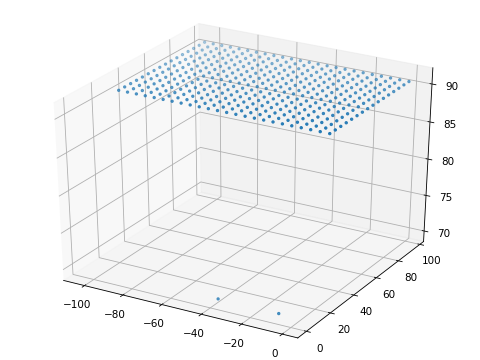

In [9]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(d.platemap['x'], d.platemap['y'], d.platemap['z'], s=5)
plt.show()

In [12]:
d.Z.move(10)

u'/0@\x03\r\n'

In [75]:
d.XY.r_xy(0,5)

':A\r\n\x03'

In [11]:
d.go_to(['name'],'A02')

In [13]:
d.exit()

# Procedure
- Primed control
- Primed chip with BSA (3.8 psi)
    - Inlet tree
    - Device w/ outlet open
    - Device w/ outlet closed (to remove air)
    - Opened outlet / closed neck valves
    - Passivated w/ BSA under flow for 1 hr


In [ ]:
d = Autosipper(Motor('config/le_motor.yaml'), ASI_Controller('config/asi_controller.yaml'))

Prime PEEK manually

- Put PEEK in W2
- Open Valves(vacuum_in, inlet)
- Open CTRL(vacuum_in)  

- 

In [ ]:
d.exit()